In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt

On importe les données

In [2]:
data_olist_final = pd.read_csv('olist_final.csv')

In [3]:
data_olist_final

,customer_state,payment_type,product_category_name_english,prix_total,montant,frequence,payment_installments,payment_value,review_score,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,price
0,SP,credit_card,Home,129.90,3.0,3,8.0,141.90,5.0,12.00,60.0,236.0,1.0,129.90
1,SP,credit_card,Health_Beauty,18.90,0.0,3,1.0,27.19,4.0,8.29,56.0,635.0,1.0,18.90
2,SC,credit_card,Office_Supplies,69.00,1.0,0,8.0,86.22,3.0,17.22,49.0,177.0,3.0,69.00
3,PA,credit_card,Technology,25.99,1.0,0,4.0,43.62,4.0,17.63,43.0,1741.0,5.0,25.99
4,SP,credit_card,Technology,180.00,4.0,3,6.0,196.89,5.0,16.89,58.0,794.0,3.0,180.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93391,PE,credit_card,Health_Beauty,1570.00,31.0,0,10.0,4134.84,5.0,248.71,54.0,478.5,1.0,785.00
93392,BA,credit_card,Baby,64.89,1.0,3,1.0,84.58,4.0,19.69,37.0,506.0,2.0,64.89
93393,MT,credit_card,Automotive,89.90,2.0,0,1.0,112.46,5.0,22.56,57.0,716.0,5.0,89.90
93394,ES,credit_card,Fashion_Accessories,115.00,2.0,3,5.0,133.69,5.0,18.69,35.0,591.0,3.0,115.00


On crée un sample pour tester notre code avec le moins de temps

In [4]:
df = data_olist_final.sample(frac=0.3, random_state=48)


In [5]:
df =df.drop(columns=["product_name_lenght"])

On encode notre code pour pouvoir visualiser 

In [6]:
df_test = df.copy()

In [7]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# Séparer les variables numériques et catégoriques
numeric_cols = df_test.select_dtypes(include=[np.number]).columns
categorical_cols = df_test.select_dtypes(include=[object]).columns

# Encoder les variables catégoriques avec OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(df_test[categorical_cols])
onehot_encoded_columns = [f'{col}_{value}' for col, categories in zip(categorical_cols, onehot_encoder.categories_) for value in categories]
onehot_encoded_df_test = pd.DataFrame(onehot_encoded, columns=onehot_encoded_columns, index=df_test.index)

# Normaliser les variables numériques
df_test[numeric_cols] = preprocessing.StandardScaler().fit_transform(df_test[numeric_cols])

# Combiner les variables numériques et catégoriques encodées en une seule dataframe
df_encoded_test = pd.concat([df_test[numeric_cols], onehot_encoded_df_test], axis=1)


/home/simplon/miniconda3/envs/k_means/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


On utilise la PCA pour savoir comment réduire nos dimensions

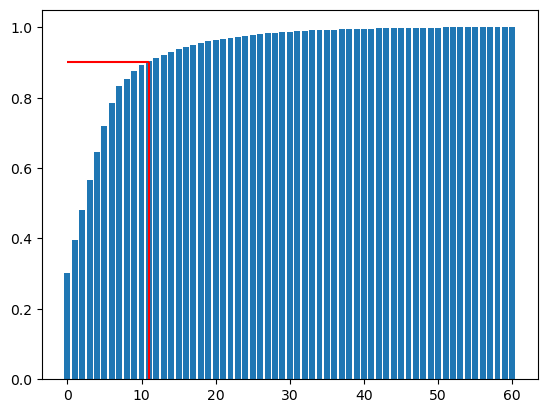

In [8]:
from sklearn.decomposition import PCA
X = df_encoded_test
n_dims = X.shape[1]
model = PCA(n_components=n_dims)
model.fit(X)

variances = model.explained_variance_ratio_

meilleur_dims = np.argmax(np.cumsum(variances) > 0.90)

import matplotlib.pyplot as plt
plt.bar(range(n_dims), np.cumsum(variances))
plt.hlines(0.90, 0, meilleur_dims, colors='r')
plt.vlines(meilleur_dims, 0, 0.90, colors='r')

On encode les colonnes objets pour pouvoir utiliser la methode du coude

In [9]:
categorical_cols = df.select_dtypes(include=[object]).columns
categorical_col_indices = [df.columns.get_loc(col) for col in categorical_cols]

Methode du coude

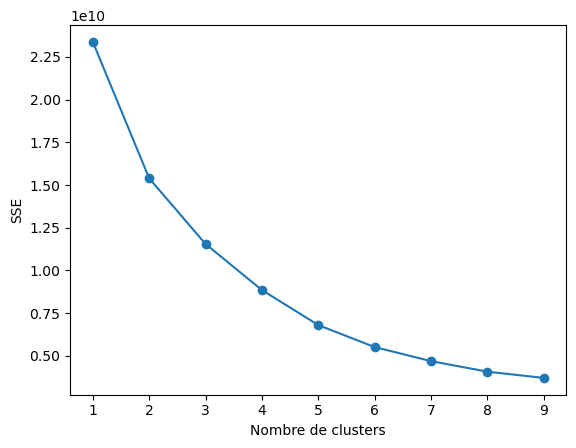

In [10]:
# Exécution de l'algorithme k-prototypes pour différents nombres de clusters
SSE = []
for cluster in range(1, 10):
    kproto = KPrototypes(n_clusters=cluster, init='Cao',max_iter=10, n_init=5,n_jobs=-2, verbose=False)
    clusters = kproto.fit_predict(df, categorical=categorical_col_indices)
    SSE.append(kproto.cost_)
    
# Tracé de la somme des distances intra-cluster pour différents nombres de clusters
plt.plot(range(1, 10), SSE, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('SSE')
plt.show()

Knee locator pour visualiser le nombre de cluster optimal

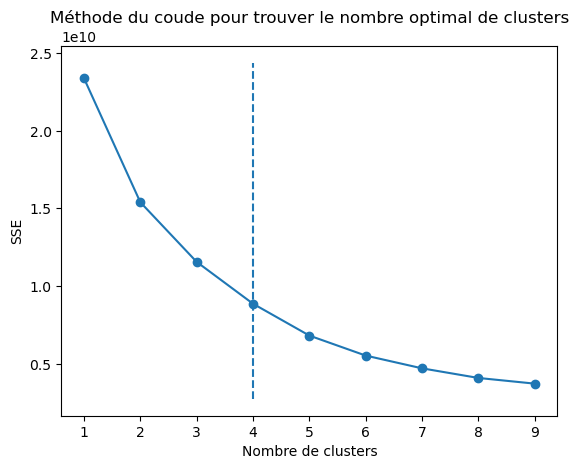

In [11]:
from kneed import KneeLocator
kneedle = KneeLocator(range(1, 10), SSE, curve='convex', direction='decreasing')
k_optimal = kneedle.elbow

# Tracé de la somme des distances intra-cluster pour différents nombres de clusters
plt.plot(range(1, 10), SSE, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('SSE')
plt.title('Méthode du coude pour trouver le nombre optimal de clusters')
plt.vlines(k_optimal, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

On applique le k prototype avec 4 clusters

In [12]:

# Appliquer l'algorithme k-prototypes
kproto = KPrototypes(n_clusters=4, init='Cao',max_iter=15, n_init=5,n_jobs=-2, verbose=False)
clusters = kproto.fit_predict(df, categorical=categorical_col_indices)


df_copy =df.copy()
# Ajouter une colonne de clusters au dataframe
df_copy['cluster'] = clusters

df_copy_radar=df_copy.copy()

On cree une copie sur lequelle travailler

In [13]:
df_copy

,customer_state,payment_type,product_category_name_english,prix_total,montant,frequence,payment_installments,payment_value,review_score,freight_value,product_description_lenght,product_photos_qty,price,cluster
78319,SP,credit_card,Books,35.90,1.0,3,1.0,52.01,5.0,16.110000,623.000000,5.0,35.900000,3
35213,SC,credit_card,Fashion_Accessories,134.90,3.0,3,2.0,153.09,4.0,18.190000,345.000000,4.0,134.900000,3
59459,SP,credit_card,Toys_Games,369.00,7.0,3,7.0,390.77,5.0,21.770000,1944.000000,1.0,369.000000,1
64535,SP,credit_card,Home,99.00,2.0,3,7.0,114.00,5.0,15.000000,188.000000,1.0,99.000000,3
59983,SP,credit_card,Sports_Leisure,30.90,1.0,3,3.0,38.29,4.0,7.390000,722.000000,2.0,30.900000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34330,SC,boleto,Home,23.90,0.0,0,1.0,39.00,5.0,15.100000,561.000000,2.0,23.900000,3
48335,SP,credit_card,Agro_Industry_Commerce,138.00,3.0,3,1.0,151.87,4.0,13.870000,1561.000000,2.0,138.000000,0
75209,PA,credit_card,Fashion_Accessories,99.90,2.0,0,4.0,129.00,5.0,29.100000,404.000000,4.0,99.900000,3
2065,GO,boleto,Sports_Leisure,99.00,2.0,3,1.0,114.44,1.0,15.440000,1301.000000,1.0,99.000000,0


On groupe notre cluster par les variable numerique et categorielle , puis nous prnons la moyenne des variables numériques , et la modalité des variables catégorielles pour pouvoir analyser les clusters.

In [14]:
mode_col = ['customer_state','payment_type','product_category_name_english']
mean_col = ['payment_installments', 'payment_value','review_score','freight_value','product_description_lenght','product_photos_qty','price']
last_col = ['prix_total','montant','frequence']

dict_agg = {}

for col in mode_col:
    dict_agg[f'{col}'] = pd.Series.mode

for col in last_col:
    dict_agg[f'{col}'] = 'last'

for col in mean_col:
    dict_agg[f'{col}'] = 'mean'

df_grouped = df_copy.groupby(df_copy['cluster']).agg(dict_agg)


Voici les cluster que l'on doit analyser

In [15]:
df_grouped

,customer_state,payment_type,product_category_name_english,prix_total,montant,frequence,payment_installments,payment_value,review_score,freight_value,product_description_lenght,product_photos_qty,price
cluster,,,,,,,,,,,,,
0,SP,credit_card,Home,99.00,2.0,3,2.959385,212.063367,4.118476,21.404235,1104.466349,2.454391,141.162489
1,SP,credit_card,Health_Beauty,59.99,1.0,3,3.217387,271.618040,4.158655,24.068438,2536.023727,2.590578,207.511275
2,SP,credit_card,Home,1957.72,39.0,3,5.763175,4043.568186,3.705370,49.612036,1078.994262,2.086214,1046.075623
3,SP,credit_card,Home,99.90,2.0,0,2.811378,158.960773,4.110291,18.807553,419.604804,2.111430,97.948729


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28019 entries, 78319 to 70330
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_state                 28019 non-null  object 
 1   payment_type                   28019 non-null  object 
 2   product_category_name_english  28019 non-null  object 
 3   prix_total                     28019 non-null  float64
 4   montant                        28019 non-null  float64
 5   frequence                      28019 non-null  int64  
 6   payment_installments           28019 non-null  float64
 7   payment_value                  28019 non-null  float64
 8   review_score                   28019 non-null  float64
 9   freight_value                  28019 non-null  float64
 10  product_description_lenght     28019 non-null  float64
 11  product_photos_qty             28019 non-null  float64
 12  price                          28019 non-n

On enncode une copy pour visualiser 

In [17]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np



# Séparer les variables numériques et catégoriques
numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
categorical_cols = df_copy.select_dtypes(include=[object]).columns

# Appliquer une transformation logarithmique sur les variables numériques
df_copy[numeric_cols] = np.log(df_copy[numeric_cols] + 1)

# Encoder les variables catégoriques avec OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(df_copy[categorical_cols])
onehot_encoded_columns = [f'{col}_{value}' for col, categories in zip(categorical_cols, onehot_encoder.categories_) for value in categories]
onehot_encoded_df_copy = pd.DataFrame(onehot_encoded, columns=onehot_encoded_columns, index=df_copy.index)

# Normaliser les variables numériques
df_copy[numeric_cols] = preprocessing.StandardScaler().fit_transform(df_copy[numeric_cols])

# Combiner les variables numériques et catégoriques encodées en une seule dataframe
df_copy_encoded = pd.concat([df_copy[numeric_cols], onehot_encoded_df_copy], axis=1)

/home/simplon/miniconda3/envs/k_means/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [18]:
df_copy_encoded

,prix_total,montant,frequence,payment_installments,payment_value,review_score,freight_value,product_description_lenght,product_photos_qty,price,...,product_category_name_english_Health_Beauty,product_category_name_english_Home,product_category_name_english_Market_place,product_category_name_english_Office_Supplies,product_category_name_english_Party_Supplies,product_category_name_english_Pet_Supplies,product_category_name_english_Signaling_Security,product_category_name_english_Sports_Leisure,product_category_name_english_Technology,product_category_name_english_Toys_Games
78319,-0.969860,-0.635814,0.651279,-0.859753,-0.931871,0.604067,-0.142833,0.050710,1.639852,-0.861200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35213,0.417038,0.414666,0.651279,-0.147157,0.237957,0.076069,0.085380,-0.712552,1.224683,0.578879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59459,1.482533,1.465145,0.651279,1.576630,1.260968,0.604067,0.425642,1.522155,-0.861822,1.685230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
64535,0.090715,-0.021323,0.651279,1.576630,-0.082829,0.604067,-0.276258,-1.495204,-0.861822,0.240043,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59983,-1.124756,-0.635814,0.651279,0.358438,-1.260228,0.076069,-1.560382,0.241307,0.061471,-1.022036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34330,-1.388303,-1.686293,-1.535441,-0.859753,-1.240593,0.604067,-0.263864,-0.084736,0.061471,-1.295688,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48335,0.441032,0.414666,0.651279,-0.859753,0.229242,0.076069,-0.421953,1.238322,0.061471,0.603793,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75209,0.100247,-0.021323,-1.535441,0.750608,0.051581,0.604067,0.980790,-0.508767,1.224683,0.249940,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2065,0.090715,-0.021323,0.651279,-0.859753,-0.078643,-2.577483,-0.222293,1.002675,-0.861822,0.240043,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
grouped_df = df_copy_encoded.groupby('cluster')


In [20]:
grouped_df.head()

,prix_total,montant,frequence,payment_installments,payment_value,review_score,freight_value,product_description_lenght,product_photos_qty,price,...,product_category_name_english_Health_Beauty,product_category_name_english_Home,product_category_name_english_Market_place,product_category_name_english_Office_Supplies,product_category_name_english_Party_Supplies,product_category_name_english_Pet_Supplies,product_category_name_english_Signaling_Security,product_category_name_english_Sports_Leisure,product_category_name_english_Technology,product_category_name_english_Toys_Games
78319,-0.969860,-0.635814,0.651279,-0.859753,-0.931871,0.604067,-0.142833,0.050710,1.639852,-0.861200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35213,0.417038,0.414666,0.651279,-0.147157,0.237957,0.076069,0.085380,-0.712552,1.224683,0.578879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59459,1.482533,1.465145,0.651279,1.576630,1.260968,0.604067,0.425642,1.522155,-0.861822,1.685230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
64535,0.090715,-0.021323,0.651279,1.576630,-0.082829,0.604067,-0.276258,-1.495204,-0.861822,0.240043,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59983,-1.124756,-0.635814,0.651279,0.358438,-1.260228,0.076069,-1.560382,0.241307,0.061471,-1.022036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
47294,0.454719,0.414666,-1.535441,-0.147157,0.230031,0.604067,-0.661940,-0.389773,-0.861822,0.618005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
53824,-0.273779,-0.635814,0.651279,-0.859753,-0.485632,0.604067,-1.282058,0.817001,0.061471,-0.138428,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
31276,0.101195,-0.021323,0.651279,-0.859753,0.174996,0.604067,1.802702,1.487765,-0.861822,0.250925,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11586,-0.069855,-0.021323,0.651279,-0.859753,-0.100900,0.604067,0.846144,0.751095,-0.861822,0.073315,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20984,-0.201374,-0.635814,0.651279,-0.859753,-0.246074,0.604067,0.538565,1.660850,1.639852,-0.063246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


On rempli les valeurs manquantes

In [21]:
from sklearn.impute import SimpleImputer

# Remplir les valeurs manquantes avec la moyenne
filled_df = grouped_df.transform(lambda x: x.fillna(x.mean()))
# Imputer pour remplacer les valeurs manquantes par la moyenne des colonnes
imputer = SimpleImputer(strategy='mean')

# Imputer les valeurs manquantes dans filled_df
filled_df = imputer.fit_transform(filled_df)

In [22]:
filled_df

array([[-0.9698597 , -0.63581369,  0.65127864, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.41703812,  0.41466578,  0.65127864, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.48253322,  1.46514525,  0.65127864, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.10024668, -0.02132259, -1.53544111, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09071522, -0.02132259,  0.65127864, ...,  1.        ,
         0.        ,  0.        ],
       [ 3.25541942,  3.90428303,  0.65127864, ...,  0.        ,
         1.        ,  0.        ]])

On teste un silhouhette score

In [23]:
from sklearn.metrics import silhouette_score
# Calculer l'indice de silhouette
silhouette = silhouette_score(filled_df, clusters, metric='euclidean')
print("Silhouette score: ", silhouette)

Silhouette score:  0.03762514690113973


On visualise les clusters.

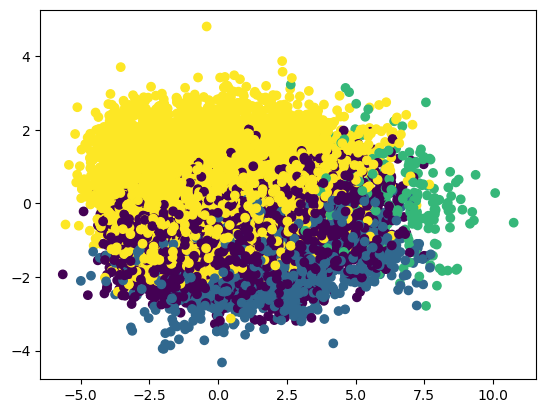

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# On choisit 4 dimensions pour la PCA
pca_components = 10

# Initialiser le modèle PCA
pca_model = PCA(n_components=pca_components, random_state=42)

# Transformer les données en utilisant la PCA
X_pca = pca_model.fit_transform(filled_df)

# Visualiser les données réduites
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)
plt.show()

In [25]:
filled_df

array([[-0.9698597 , -0.63581369,  0.65127864, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.41703812,  0.41466578,  0.65127864, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.48253322,  1.46514525,  0.65127864, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.10024668, -0.02132259, -1.53544111, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09071522, -0.02132259,  0.65127864, ...,  1.        ,
         0.        ,  0.        ],
       [ 3.25541942,  3.90428303,  0.65127864, ...,  0.        ,
         1.        ,  0.        ]])

On reteste via laa methode des eboulis si on doit reduire nos dimensions

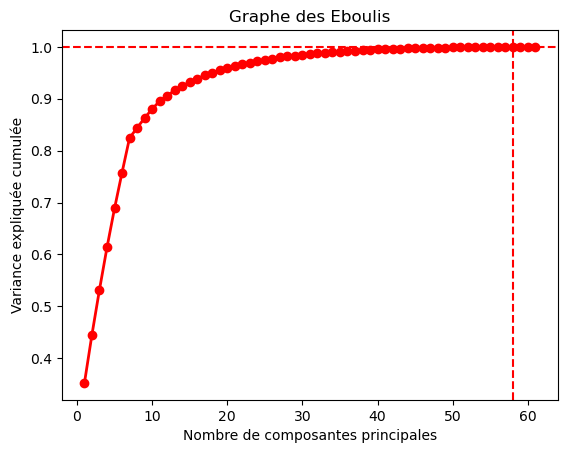

In [26]:

# Instancier l'objet PCA avec toutes les composantes principales
pca = PCA()

# Adapter le modèle PCA aux données
pca.fit(filled_df)

# Calculer la variance expliquée par chaque composante
variance_ratio = pca.explained_variance_ratio_

# Calculer la somme cumulée des variances expliquées
cumulative_variances = np.cumsum(variance_ratio)

# Afficher le graphe des Eboulis
plt.plot(np.arange(1, len(variance_ratio)+1), cumulative_variances, 'ro-', linewidth=2)
plt.title('Graphe des Eboulis')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')

# Ajouter des lignes verticales pour représenter les points d'inflexion de la courbe
diff_cumulative_variances = np.diff(cumulative_variances)
change_in_cumulative_variances = np.diff(diff_cumulative_variances)
optimal_components = np.argmax(change_in_cumulative_variances) + 1
plt.axvline(x=optimal_components, color='r', linestyle='--')
plt.axhline(y=cumulative_variances[optimal_components-1], color='r', linestyle='--')

plt.show()

Faire un radar plot
faire un dataframe à partir des clusters et commencer à visualiser

In [27]:
df_radar=df_grouped.reset_index()

In [28]:
df_radar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cluster                        4 non-null      uint64 
 1   customer_state                 4 non-null      object 
 2   payment_type                   4 non-null      object 
 3   product_category_name_english  4 non-null      object 
 4   prix_total                     4 non-null      float64
 5   montant                        4 non-null      float64
 6   frequence                      4 non-null      int64  
 7   payment_installments           4 non-null      float64
 8   payment_value                  4 non-null      float64
 9   review_score                   4 non-null      float64
 10  freight_value                  4 non-null      float64
 11  product_description_lenght     4 non-null      float64
 12  product_photos_qty             4 non-null      float64

In [29]:
df_radar.columns

Index(['cluster', 'customer_state', 'payment_type',
       'product_category_name_english', 'prix_total', 'montant', 'frequence',
       'payment_installments', 'payment_value', 'review_score',
       'freight_value', 'product_description_lenght', 'product_photos_qty',
       'price'],
      dtype='object')

In [30]:
df_radar = df_radar[['cluster', 'customer_state', 'payment_type',
       'product_category_name_english', 'prix_total', 'montant', 'frequence',
       'payment_installments', 'payment_value', 'review_score',
       'freight_value', 'product_description_lenght', 'product_photos_qty',
       'price']]

In [31]:
df_radar

,cluster,customer_state,payment_type,product_category_name_english,prix_total,montant,frequence,payment_installments,payment_value,review_score,freight_value,product_description_lenght,product_photos_qty,price
0,0,SP,credit_card,Home,99.00,2.0,3,2.959385,212.063367,4.118476,21.404235,1104.466349,2.454391,141.162489
1,1,SP,credit_card,Health_Beauty,59.99,1.0,3,3.217387,271.618040,4.158655,24.068438,2536.023727,2.590578,207.511275
2,2,SP,credit_card,Home,1957.72,39.0,3,5.763175,4043.568186,3.705370,49.612036,1078.994262,2.086214,1046.075623
3,3,SP,credit_card,Home,99.90,2.0,0,2.811378,158.960773,4.110291,18.807553,419.604804,2.111430,97.948729


In [32]:
numeric_cols = df_radar.select_dtypes(include=[np.number]).columns

In [33]:
for i in numeric_cols : 
    df_radar[i] = (df_radar[i]/df_radar[i].max())*5

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28019 entries, 78319 to 70330
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_state                 28019 non-null  object 
 1   payment_type                   28019 non-null  object 
 2   product_category_name_english  28019 non-null  object 
 3   prix_total                     28019 non-null  float64
 4   montant                        28019 non-null  float64
 5   frequence                      28019 non-null  int64  
 6   payment_installments           28019 non-null  float64
 7   payment_value                  28019 non-null  float64
 8   review_score                   28019 non-null  float64
 9   freight_value                  28019 non-null  float64
 10  product_description_lenght     28019 non-null  float64
 11  product_photos_qty             28019 non-null  float64
 12  price                          28019 non-n

In [35]:
df_copy_radar["cluster"].value_counts()

3    17080
0     8539
1     2174
2      226
Name: cluster, dtype: int64

In [36]:
df_radar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cluster                        4 non-null      float64
 1   customer_state                 4 non-null      object 
 2   payment_type                   4 non-null      object 
 3   product_category_name_english  4 non-null      object 
 4   prix_total                     4 non-null      float64
 5   montant                        4 non-null      float64
 6   frequence                      4 non-null      float64
 7   payment_installments           4 non-null      float64
 8   payment_value                  4 non-null      float64
 9   review_score                   4 non-null      float64
 10  freight_value                  4 non-null      float64
 11  product_description_lenght     4 non-null      float64
 12  product_photos_qty             4 non-null      float64

In [37]:
df_float_radar = df_radar.select_dtypes('float64')



In [38]:
import plotly.graph_objects as go
# Créer une figure en radar pour chaque cluster
fig = go.Figure()

for cluster, row in df_float_radar.iterrows():
    values = row.values.tolist()




    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=df_float_radar.columns,
        fill='toself',
        name=f'Cluster {cluster}'
    ))

# Mettre en forme la figurenum_cols,
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0,5]
        ),
    ),
    showlegend=True,
    width=780,
    height=780

)

# Afficher la figure
fig.show()
figsize = (60,60)

Piste pour ameliorer 

Essayons d'autre alogorithmes de clusterisation 

In [39]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np



# Séparer les variables numériques et catégoriques
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=[object]).columns

# Appliquer une transformation logarithmique sur les variables numériques
df[numeric_cols] = np.log(df[numeric_cols] + 1)

# Encoder les variables catégoriques avec OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(df[categorical_cols])
onehot_encoded_columns = [f'{col}_{value}' for col, categories in zip(categorical_cols, onehot_encoder.categories_) for value in categories]
onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=onehot_encoded_columns, index=df.index)

# Normaliser les variables numériques
df[numeric_cols] = preprocessing.StandardScaler().fit_transform(df[numeric_cols])

# Combiner les variables numériques et catégoriques encodées en une seule dataframe
df_encoded = pd.concat([df[numeric_cols], onehot_encoded_df], axis=1)

/home/simplon/miniconda3/envs/k_means/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



On va considerer k = 4 , au vue des résultats données par la méthode précedentes 

In [40]:
df_encoded

,prix_total,montant,frequence,payment_installments,payment_value,review_score,freight_value,product_description_lenght,product_photos_qty,price,...,product_category_name_english_Health_Beauty,product_category_name_english_Home,product_category_name_english_Market_place,product_category_name_english_Office_Supplies,product_category_name_english_Party_Supplies,product_category_name_english_Pet_Supplies,product_category_name_english_Signaling_Security,product_category_name_english_Sports_Leisure,product_category_name_english_Technology,product_category_name_english_Toys_Games
78319,-0.969860,-0.635814,0.651279,-0.859753,-0.931871,0.604067,-0.142833,0.050710,1.639852,-0.861200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35213,0.417038,0.414666,0.651279,-0.147157,0.237957,0.076069,0.085380,-0.712552,1.224683,0.578879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59459,1.482533,1.465145,0.651279,1.576630,1.260968,0.604067,0.425642,1.522155,-0.861822,1.685230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
64535,0.090715,-0.021323,0.651279,1.576630,-0.082829,0.604067,-0.276258,-1.495204,-0.861822,0.240043,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59983,-1.124756,-0.635814,0.651279,0.358438,-1.260228,0.076069,-1.560382,0.241307,0.061471,-1.022036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34330,-1.388303,-1.686293,-1.535441,-0.859753,-1.240593,0.604067,-0.263864,-0.084736,0.061471,-1.295688,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48335,0.441032,0.414666,0.651279,-0.859753,0.229242,0.076069,-0.421953,1.238322,0.061471,0.603793,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75209,0.100247,-0.021323,-1.535441,0.750608,0.051581,0.604067,0.980790,-0.508767,1.224683,0.249940,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2065,0.090715,-0.021323,0.651279,-0.859753,-0.078643,-2.577483,-0.222293,1.002675,-0.861822,0.240043,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [41]:

# Remplir les valeurs manquantes avec la moyenne
filled_df_dbscan = df_encoded.transform(lambda x: x.fillna(x.mean()))
# Imputer pour remplacer les valeurs manquantes par la moyenne des colonnes
imputer = SimpleImputer(strategy='mean')

# Imputer les valeurs manquantes dans filled_df_dbscan
filled_df_dbscan = imputer.fit_transform(filled_df_dbscan)

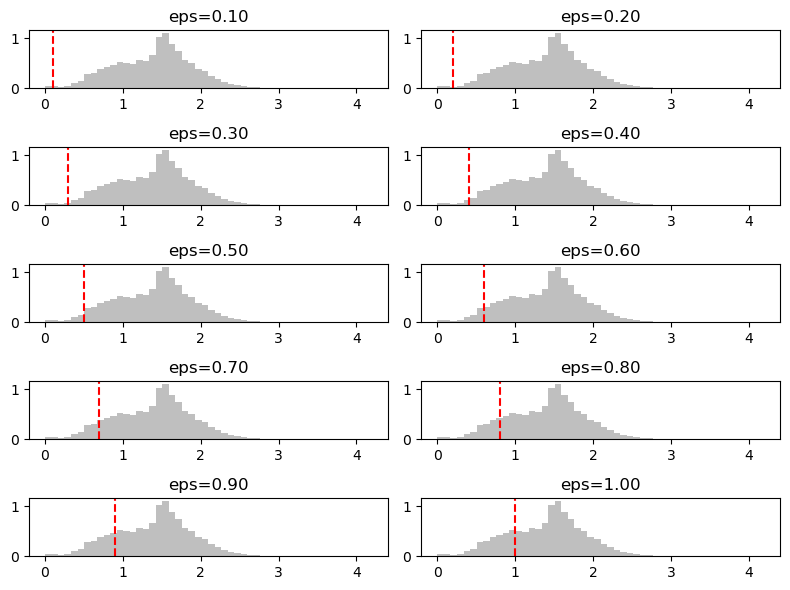

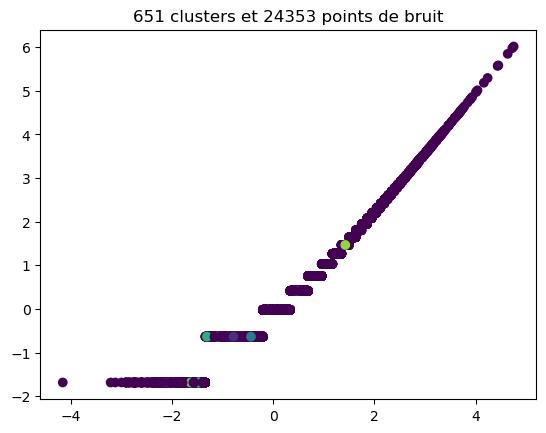

In [42]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Générer des données aléatoires
X = filled_df_dbscan

# Calculer la distance au k-ième voisin le plus proche pour chaque point
k = 4
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, indices = nbrs.kneighbors(X)
dist_k = distances[:, k-1]

# Choisir une grille de valeurs pour eps et min_samples
eps_grid = np.linspace(0.1, 1, 10)
min_samples_grid = [2, 3, 4, 5]

# Appliquer DBSCAN pour chaque paire de valeurs (eps, min_samples) dans la grille
n_clusters = np.zeros((len(eps_grid), len(min_samples_grid)))
n_noise = np.zeros((len(eps_grid), len(min_samples_grid)))

for i, eps in enumerate(eps_grid):
    for j, min_samples in enumerate(min_samples_grid):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X)
        n_clusters[i, j] = len(np.unique(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
        n_noise[i, j] = np.sum(dbscan.labels_ == -1)

# Tracer la courbe de décroissance de la densité pour chaque valeur de k
plt.figure(figsize=(8, 6))

for i, eps in enumerate(eps_grid):
    plt.subplot(5, 2, i+1)
    plt.hist(dist_k, bins=50, density=True, alpha=0.5, color='gray')
    plt.axvline(eps, color='red', linestyle='--')
    plt.title(f"eps={eps:.2f}")
    
plt.tight_layout()
plt.show()

# Trouver la valeur optimale de eps en examinant les courbes de décroissance de la densité
eps_opt = 0.5  # par exemple, on choisit le "creux" à eps=0.5

# Appliquer DBSCAN avec eps_opt et un min_samples approprié
min_samples_opt = 3
dbscan_opt = DBSCAN(eps=eps_opt, min_samples=min_samples_opt)
dbscan_opt.fit(X)

# Afficher le résultat du clustering
plt.scatter(X[:, 0], X[:, 1], c=dbscan_opt.labels_)
plt.title(f"{n_clusters[5, 1]:.0f} clusters et {n_noise[5, 1]:.0f} points de bruit")
plt.show()


In [43]:
#On sauvegarde notre nombre de cluster ici
cluster_pour_pca =int(n_clusters[5, 1])
cluster_pour_pca

651

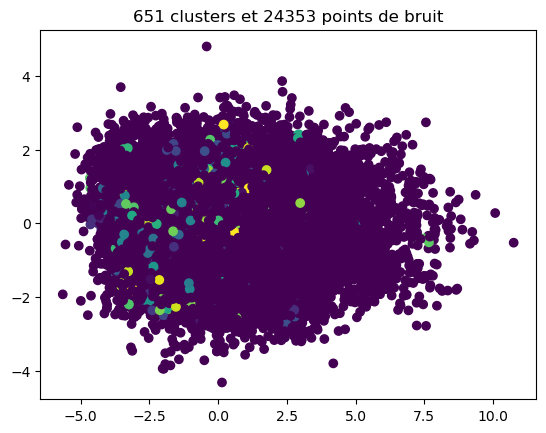

In [44]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Générer des données aléatoires
X = filled_df_dbscan

# Calculer la distance au k-ième voisin le plus proche pour chaque point
k = 4
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, indices = nbrs.kneighbors(X)
dist_k = distances[:, k-1]

# Choisir une grille de valeurs pour eps et min_samples
eps_grid = np.linspace(0.1, 1, 10)
min_samples_grid = [2, 3, 4, 5]

# Appliquer DBSCAN pour chaque paire de valeurs (eps, min_samples) dans la grille
n_clusters = np.zeros((len(eps_grid), len(min_samples_grid)))
n_noise = np.zeros((len(eps_grid), len(min_samples_grid)))

for i, eps in enumerate(eps_grid):
    for j, min_samples in enumerate(min_samples_grid):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X)
        n_clusters[i, j] = len(np.unique(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
        n_noise[i, j] = np.sum(dbscan.labels_ == -1)

# Trouver la valeur optimale de eps en examinant les courbes de décroissance de la densité
eps_opt = 0.5  # par exemple, on choisit le "creux" à eps=0.5

# Appliquer DBSCAN avec eps_opt et un min_samples approprié
min_samples_opt = 3
dbscan_opt = DBSCAN(eps=eps_opt, min_samples=min_samples_opt)
dbscan_opt.fit(X)

# Reduce dimensionality of data with PCA
pca = PCA(n_components=60)
X_pca = pca.fit_transform(X)

# Visualize the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_opt.labels_, cmap='viridis')
plt.title(f"{n_clusters[5, 1]:.0f} clusters et {n_noise[5, 1]:.0f} points de bruit")
plt.show()

Essai de visualisation de carte

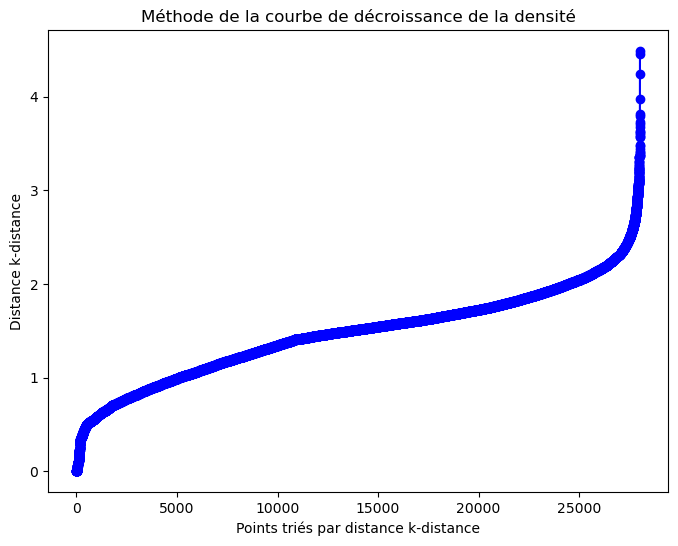

In [45]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np


# Calculer les distances k-distance
k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(df_encoded)
distances, indices = nbrs.kneighbors(df_encoded)
k_distances = np.sort(distances[:,k-1], axis=0)

# Tracer la courbe de décroissance de la densité
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(k_distances, 'bo-')
ax.set_xlabel('Points triés par distance k-distance')
ax.set_ylabel('Distance k-distance')
ax.set_title('Méthode de la courbe de décroissance de la densité')
plt.show()

In [46]:
df_copy_dbscan =df.copy()

Si on veux aller plus loin Creation de carte 

In [47]:
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl

olist_orders = pd.read_csv('olist_orders_dataset.csv')
olist_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
olist_customer = pd.read_csv('olist_customers_dataset.csv')
olist_order_items = pd.read_csv('olist_order_items_dataset.csv')

In [48]:
df_orders = olist_orders.merge(olist_customer, how='left', on='customer_id')


In [49]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,2018,7,Jul,201807,20180724,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,2017,11,Nov,201711,20171118,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,2018,2,Feb,201802,20180213,13,1,Tue,21,Night


In [50]:
# Merging orders and order_items
df_orders_items = df_orders.merge(olist_order_items, how='left', on='order_id')

# Using the API to bring the region to the data
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = [c['UF'] for c in json.loads(r.text)]
br_info = pd.DataFrame(content)
br_info['nome_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis=1, inplace=True)
br_info.drop_duplicates(inplace=True)

# Threting geolocations outside brazilian map

#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo_prep = olist_geolocation[olist_geolocation.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng <=  -34.79314722]
geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()

# Merging all the informations
df_orders_items = df_orders_items.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
df_orders_items = df_orders_items.merge(geo_group, how='left', left_on='customer_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix')
df_orders_items.head()

SSLError: HTTPSConnectionPool(host='servicodados.ibge.gov.br', port=443): Max retries exceeded with url: /api/v1/localidades/mesorregioes (Caused by SSLError(SSLError(1, '[SSL: UNSAFE_LEGACY_RENEGOTIATION_DISABLED] unsafe legacy renegotiation disabled (_ssl.c:992)')))

In [ ]:
# Filtering data between 201701 and 201808
df_orders_filt = df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201701)]
df_orders_filt = df_orders_filt[(df_orders_filt['order_purchase_year_month'].astype(int) <= 201808)]

In [ ]:
# Grouping geolocation data for plotting a heatmap
heat_data = df_orders_filt.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count().iloc[:, :3]

# Creating a mapa using folium
map1 = folium.Map(
    location=[-15, -50], 
    zoom_start=4.0, 
    tiles='cartodbdark_matter'
)

# Plugin: HeatMap
HeatMap(
    name='Mapa de Calor',
    data=heat_data,
    radius=10,
    max_zoom=13
).add_to(map1)

map1

Isolation forest , recherche d'anomalie